In [1]:
import shutil
import pathlib
import tempfile
import tensorflow_docs.plots
import tensorflow_docs.modeling

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

from  IPython import display
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
# For tensorboard loggin

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz ,[float(),]*(FEATURES+1), compression_type = "GZIP")

In [6]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


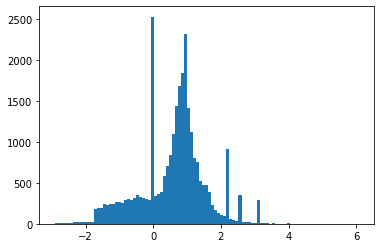

In [8]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [10]:
# Dataset.cache ensures we don't have to reload dataset on each epoch

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [12]:
# Get optimizer as an LR Scheduler

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps = STEPS_PER_EPOCH*1000,
  decay_rate = 1,
  staircase = False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

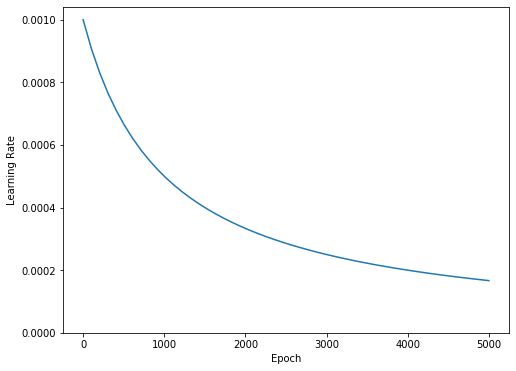

In [13]:
# See decay on plot

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [14]:
def get_callbacks(name):
    
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', patience = 200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [15]:
def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):
    
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = [
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits = True, name = 'binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = max_epochs,
    validation_data = validate_ds,
    callbacks = get_callbacks(name),
    verbose = 0)

  return history

# Show overfit

Very tiny model as a starter

In [16]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [17]:
size_histories = {}

In [18]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5221,  binary_crossentropy:0.8934,  loss:0.8934,  val_accuracy:0.4820,  val_binary_crossentropy:0.8016,  val_loss:0.8016,  
....................................................................................................
Epoch: 100, accuracy:0.5923,  binary_crossentropy:0.6282,  loss:0.6281,  val_accuracy:0.5840,  val_binary_crossentropy:0.6257,  val_loss:0.6257,  
....................................................................................................
Epoch: 200, accuracy:0.62

(0.5, 0.7)

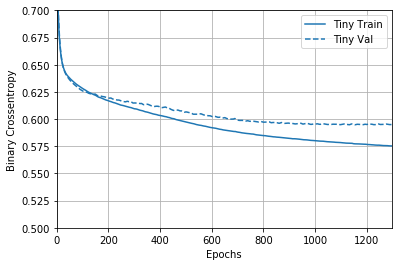

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

Small Model 

In [20]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape = (FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [21]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', optimizer = 'adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5059,  binary_crossentropy:0.7582,  loss:0.7582,  val_accuracy:0.4770,  val_binary_crossentropy:0.7408,  val_loss:0.7408,  
....................................................................................................
Epoch: 100, accuracy:0.6100,  binary_crossentropy:0.6180,  loss:0.6180,  val_accuracy:0.5790,  val_binary_crossentropy:0.6264,  val_loss:0.

In [22]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [23]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium", optimizer = 'adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4915,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.4820,  val_binary_crossentropy:0.6840,  val_loss:0.6840,  
....................................................................................................
E

In [24]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large", optimizer = 'adam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5076,  binary_crossentropy:0.7847,  loss:0.7847,  val_accuracy:0.4650,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

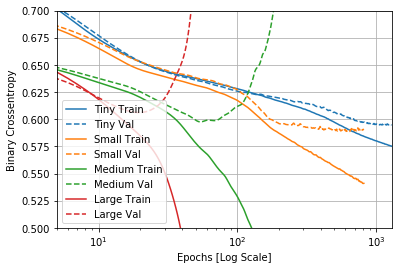

In [26]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

As you can see the large model is clearly overfitting whereas the tiny model underfits

In [28]:
# Open an embedded TensorBoard viewer inside a notebook:
%load_ext tensorboard
%tensorboard --logdir {logdir}/sizes

In [29]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors = True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpuli3txin/tensorboard_logs/regularizers/Tiny')

In [30]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## Strategies to prevent Overfitting

### Weight Regularization

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In [31]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2", optimizer = 'adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5116,  binary_crossentropy:0.7763,  loss:2.2809,  val_accuracy:0.5680,  val_binary_crossentr

(0.5, 0.7)

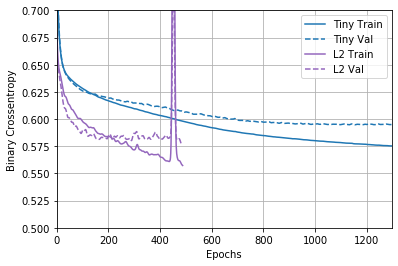

In [32]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the "L2" regularized model is now much more competitive with the the "Tiny" model. This "L2" model is also much more resistant to overfitting than the "Large" model it was based on despite having the same number of parameters.

### Add Dropout

In [33]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

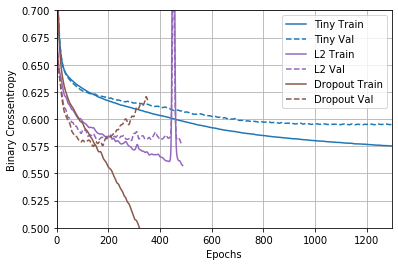

In [34]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### Combined L2 + dropout

In [35]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu', input_shape = (FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

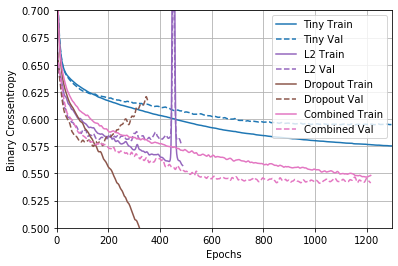

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])